# Load data

Dataset contains 12600 datapoints. Features are spike counts per second for 76 neurons. Position is x and y coordinates of rat.

In [1]:
from scipy.io import loadmat

data = loadmat("concatenated_1000ms_from250_speed10_bin100.mat")
features = data["features"]
position = data["position"]

print features.shape, position.shape

(12600, 76) (12600, 2)


## Plot rat location

Left figure shows that rat explores almost all of the arena, but center has more data points.

Right figure shows three example trajectories. The data contains 100-point sequences that are shuffled.

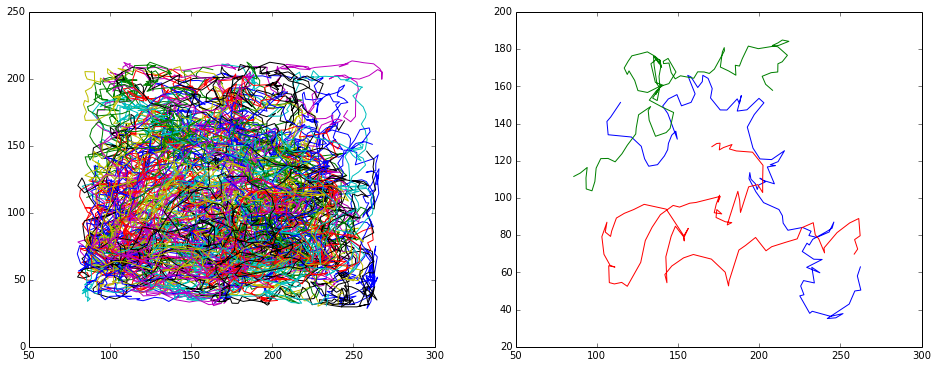

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
pos = np.reshape(position, (126, 100, 2))
plt.plot(pos[:,:,0].T, pos[:,:,1].T);

plt.subplot(1,2,2)
plt.plot(position[:100,0], position[:100,1])
plt.plot(position[100:200,0], position[100:200,1])
plt.plot(position[200:300,0], position[200:300,1]);

## Plot neuron activity

Left figure shows activity of each neuron over time. Y axis is 76 neurons and X axis is 100 time points. Color is the number of spikes in 1s window. Time steps are with interval 250ms, which means that windows are overlapping.

Right figure shows corresponding trajectory. The rat starts from top left and finishes at bottom right.

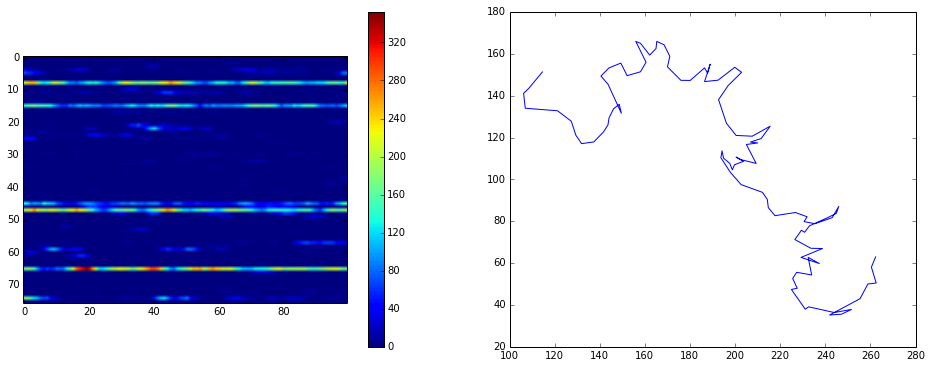

In [3]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(features[:100].T)
plt.colorbar();

plt.subplot(1,2,2)
plt.plot(position[:100,0], position[:100,1]);


# Split into training and test set

Currently using first 80% as training and last 20% as test set. Because 100 timestep splits are already shuffled, we don't need to randomize them. 

In [4]:
nr_samples = features.shape[0]
nr_train = 10100
nr_test = nr_samples - nr_train

train_X = features[:nr_train]
train_Y = position[:nr_train]
test_X = features[nr_train:]
test_Y = position[nr_train:]

print train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

(10100, 76) (10100, 2) (2500, 76) (2500, 2)


## Helper function to calculate mean distance

Used with GridSearchCV.

In [5]:
def mean_distance(estimator, X, y):
    pred_y = estimator.predict(X)
    return np.mean(np.sqrt(np.sum((pred_y - y) ** 2, axis=1)))

def mean_distance_scoring(estimator, X, y):
    return -mean_distance(estimator, X, y)

# Linear regression

Result is as expected. Model does not overfit, on contrary - training error is bigger than test.

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np

lm = LinearRegression()
lm.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f" % \
    (mean_distance(lm, train_X, train_Y), mean_distance(lm, test_X, test_Y))

Train mean distance 38.634165, test mean distance: 36.434455


# KNN Regression

KNN is a simple way to check if test set contains training set duplicates. As KNN result is bad, there must be no duplicates.

In [7]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(train_X, train_Y)
train_pred_Y = knn.predict(train_X)
test_pred_Y = knn.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(knn, train_X, train_Y), mean_distance(knn, test_X, test_Y), knn.score(test_X, test_Y))

Train mean distance 22.671016, test mean distance: 39.575747, test R^2 score 0.318577


## Grid search

Do a grid search to find the best parameters. Parameters we are evaluating:
 * **n_neighbors** - number of neighbors to consider,
 * **weights** - if distance of neighbor affects the influence of that neighbor.

Grid search didn't improve the result on test result. Result on training set improved, probably because of distance weighting.

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_neighbors': [1, 5, 10], 'weights': ['uniform', 'distance']}]

cv = GridSearchCV(KNeighborsRegressor(), tuned_parameters, scoring=mean_distance_scoring, cv=5, n_jobs=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

{'n_neighbors': 10, 'weights': 'distance'} -45.0699722014
Train mean distance 0.000000, test mean distance: 39.381020, test R^2 score -39.381020


/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Plot how parameters affect the result. Distance weighting improves the result a little. Increasing number of neighbors seems to improve the result as well, but not too much above 5.

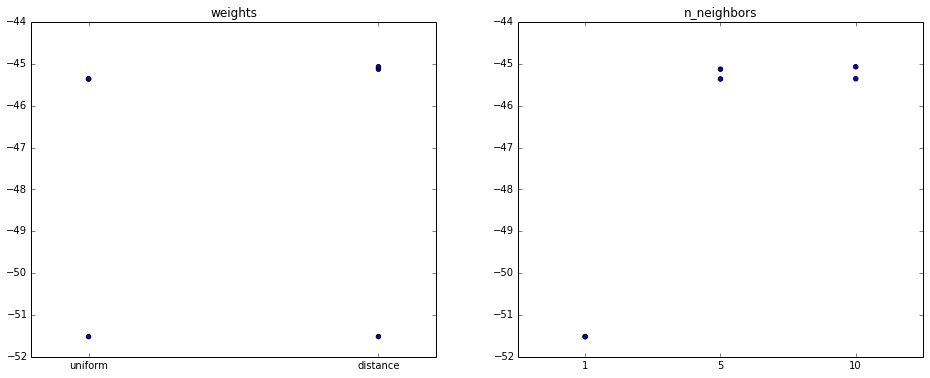

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,6))
    ncols = int(math.ceil(math.sqrt(len(params))))
    nrows = int(math.ceil(len(params) / ncols))
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()